# Classificando nomes com uma *Character-Level RNN*

Esse notebook foi criado com base no tutorial do PyTorch: <br> 
https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb

### Problema: Dado um nome próprio de entrada, classificar esse nome de acordo com a nacionalidade a que ele pertence.

Entrada: **Hinton**

(-0.47) Scottish

(-1.52) English

(-3.57) Irish


-

Entrada: **Schmidhuber**

(-0.19) German

(-2.48) Czech

(-2.68) Dutch

### Import de bibliotecas

In [39]:
# Para os dados
import unicodedata
import string
import sys, random, os

# Para o processamento e análise
import torch
from torch import nn
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
args = {
    'lr': 5e-5,
    'regularizacao': 1e-7,
    'num_epocas': 40,
}
args['device'] = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dados de entrada

### Importando dataset

In [41]:
# comente as duas linhas seguintes caso rode mais de uma vez
!wget https://download.pytorch.org/tutorial/data.zip #
!unzip data.zip #
############################################################

--2022-02-26 22:30:26--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.67.65.26, 18.67.65.118, 18.67.65.73, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.67.65.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip.7’

data.zip.7          100%[===================>]   2.75M  --.-KB/s    in 0.04s   

2022-02-26 22:30:26 (63.2 MB/s) - ‘data.zip.7’ saved [2882130/2882130]

Archive:  data.zip
replace data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/eng-fra.txt        
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  infla

In [42]:
# Transforma um arquivo de nomes em listas e/ou arrays (nomes, rotulos)
def readLines(filename):
    lines     = open(filename).read().strip().split('\n')
    nomes     = [unicodedata.normalize('NFKD', line).encode('ascii', 'ignore') for line in lines]
    categoria = filename.split('/')[-1].split('.')[0]
    rotulos   = np.repeat( categoria, len(nomes) )

    return nomes, rotulos 


root_path = 'data/names/'
arquivos = sorted(os.listdir(root_path))
categorias = [a[:-4] for a in arquivos]

dados, rotulos = [], []
samples_perclass = []

for file_name in arquivos:
  retorno = readLines(os.path.join(root_path,file_name))
  dados.append(retorno[0])
  rotulos.append(retorno[1])

  samples_perclass.append( (file_name, len(retorno[0])) )


print(samples_perclass, )
print('Minimo amostras', min(samples_perclass, key= lambda k: k[1]), '\n' )

print(dados[categorias.index('Portuguese')][0:10])
print(rotulos[categorias.index('Portuguese')][0:10])

[('Arabic.txt', 2000), ('Chinese.txt', 268), ('Czech.txt', 519), ('Dutch.txt', 297), ('English.txt', 3668), ('French.txt', 277), ('German.txt', 724), ('Greek.txt', 203), ('Irish.txt', 232), ('Italian.txt', 709), ('Japanese.txt', 991), ('Korean.txt', 94), ('Polish.txt', 139), ('Portuguese.txt', 74), ('Russian.txt', 9408), ('Scottish.txt', 100), ('Spanish.txt', 298), ('Vietnamese.txt', 73)]
Minimo amostras ('Vietnamese.txt', 73) 

[b'Abreu', b'Albuquerque', b'Almeida', b'Alves', b'Araujo', b'Araullo', b'Barros', b'Basurto', b'Belo', b'Cabral']
['Portuguese' 'Portuguese' 'Portuguese' 'Portuguese' 'Portuguese'
 'Portuguese' 'Portuguese' 'Portuguese' 'Portuguese' 'Portuguese']


### Convertendo os dados para tensor

**Convertendo os rótulos para tensor**

Representação One-Hot de 18 categorias de idiomas que queremos prever.

In [43]:
def label2tensor(rotulos):
  rotulos_tns = torch.zeros( len(rotulos), 1, dtype=torch.int64 )
  for k, rotulo in enumerate(rotulos):
    idx = categorias.index(rotulo)
    rotulos_tns[k][0] = idx
  return rotulos_tns

rotulos_arabe = rotulos[0]
rotulos_tns = label2tensor(rotulos_arabe)
print(type(rotulos_tns), rotulos_arabe[0], rotulos_tns[0])

<class 'torch.Tensor'> Arabic tensor([0])


**Convertendo os nomes para tensor**

Aqui também usaremos a representação One-Hot, porém teremos que trabalhar com uma lista de tensores, pois os nomes tem comprimentos diferentes. Mais à frente no curso aprenderemos a lidar com isso da forma certa!

In [44]:
caracteres_validos = string.ascii_letters
print(caracteres_validos)
tam_dicionario = len(caracteres_validos)

def nome2tensor(nome):
  tns = torch.zeros( len(nome), tam_dicionario )
  
  for k, letra in enumerate(nome.decode('utf-8')):
    idx = caracteres_validos.find(letra)
    tns[k, idx] = 1

  return tns

dados_arabe = dados[0]
dados_tns = [nome2tensor(dado) for dado in dados_arabe]
print(dados_arabe[0].decode('utf-8')[0],'\n', dados_tns[0][0])


abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ
K 
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


**Amostrando batch balanceado**

In [45]:
num_amostras = min(samples_perclass, key= lambda k: k[1])[1]

def sample_batch(size=num_amostras):
  dados_batch, rotulos_batch = [], []
  for cat in categorias:
    
    amostras_cat = dados[categorias.index(cat)]
    idx = np.random.choice(range(len(amostras_cat)), size=size)
    
    dados_batch.extend([ r for k, r in enumerate(dados[categorias.index(cat)]) if k in idx])
    rotulos_batch.extend([ r for k, r in enumerate(rotulos[categorias.index(cat)]) if k in idx])

  dados_tns = [nome2tensor(dado) for dado in dados_batch]
  return dados_tns, label2tensor(rotulos_batch)

dados_batch, rotulos_batch = sample_batch()
print(len(dados_batch), dados_batch[0].size(), rotulos_batch.size())

1140 torch.Size([3, 52]) torch.Size([1140, 1])


### Por fim, vamos separar dados de treino e teste.

In [46]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, Ytrain, Ytest = train_test_split(dados_tns, rotulos_tns, test_size=0.2)
print(len(Xtrain), len(Xtest))

1600 400


## Modelo Recorrente

* Implemente um modelo para classificação de nomes próprios (série de caracteres) usando apenas camadas *RNNCell*, *Linear* e ativação *LogSoftmax*
* Cada entrada (caracter) possui dimensão (52): alfabeto maiúsculo e minúsculo
* *Hidden size* possui dimensão (256): hiperparâmetro 
* Saída possui dimensão (18): vetor de probabilidade de classes
* Batch size = 1 **pra não termos que lidar com as sequências de tamanho variável.**

### Links úteis

RNNCell: https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html#torch.nn.RNNCell

Linear: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear

Non-linear activations: https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html#torch.nn.LogSoftmax

In [47]:
class RNN(nn.Module):
    def __init__(self, tam_entrada, tam_feature, tam_saida):
        super(RNN, self).__init__()
        
        self.tam_entrada = tam_entrada
        self.tam_feature = tam_feature
        self.tam_saida   = tam_saida
        
        self.rnn    = nn.RNNCell(self.tam_entrada, self.tam_feature)
        self.linear = nn.Linear(self.tam_feature, self.tam_saida)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, nome):
      
        # Inicialize o estado interno da RNN
        hidden = torch.zeros(1, self.tam_feature).to(args['device'])
        
        for letra in nome:
          letra = letra.unsqueeze(0)
          hidden = self.rnn(letra, hidden)
        
        saida = self.linear(hidden)
        saida = self.softmax(saida) 
        return saida

tam_feature = 256
model = RNN(tam_dicionario, tam_feature, len(categorias))
model.to(args['device'])

RNN(
  (rnn): RNNCell(52, 256)
  (linear): Linear(in_features=256, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=None)
)

## Loss e Otimizador

In [48]:
criterion = nn.NLLLoss().to(args['device']) 
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['regularizacao'])

## Treinamento

A otimização é um processo que tem uma raíz muito bem definida de passo a passo, sempre fazemos:
* Carregar os dados e colocar no dispositivo de hardware adequado
* Forward do dado na rede
* Cálculo da função de custo (no nosso caso uma função composta)
* Passos de Otimização
  * Zerar os gradientes do otimizador (`optimizer.zero_grad()`)
  * Calcular os gradientes com base na loss (`loss.backward()`)
  * Passo de otimização (`optimizer.step()`)

Apesar de cada solução ter pequenas variações em um ou mais passos do fluxo, o esqueleto é sempre o mesmo. 

In [49]:
def forward(X, Y, etapa):
  if etapa == 'Treino': model.train()
  else: model.eval()

  acuracia = 0.
  loss_epoca = []
  for k, (dado, rotulo) in enumerate(zip(X, Y)):
      
    dado = dado.to(args['device'])
    rotulo = rotulo.to(args['device'])

    saida = model(dado)
    loss = criterion(saida, rotulo)
    loss_epoca.append(loss.detach().cpu().numpy())

    _, pred = torch.max(saida, axis=-1)
    acuracia += 1 if pred[0].item() == rotulo[0].item() else 0

    if etapa == 'Treino':
      # Otimização
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  loss_epoca = np.asarray(loss_epoca).ravel()
  acuracia   = acuracia/float(len(loss_epoca))
  print('\n','*'*15 + etapa + '*'*15 )
  print('Epoca: {:}, Loss: {:.4f} +/- {:.4f}, Acurácia: {:.4f}'.format(epoca, loss_epoca.mean(), 
                                                                        loss_epoca.std(), 
                                                                        acuracia
                                                                       )) 
  return loss_epoca.mean(), acuracia

In [50]:
loss_treino, loss_test = [], []
acc_treino, acc_test = [], []

dados_test, rotulos_test = sample_batch(size=5)
for epoca in range(50):

  dados_tns, rotulos_tns = sample_batch()

  loss, acuracia = forward(dados_tns, rotulos_tns, 'Treino')
  loss_treino.append(loss)
  acc_treino.append(acuracia)  

  loss, acuracia = forward(dados_test, rotulos_test, 'Teste')
  loss_test.append(loss)
  acc_test.append(acuracia)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



 ***************Treino***************
Epoca: 0, Loss: 2.6870 +/- 0.6588, Acurácia: 0.1420

 ***************Teste***************
Epoca: 0, Loss: 3.0892 +/- 0.7815, Acurácia: 0.0333

 ***************Treino***************
Epoca: 1, Loss: 2.6340 +/- 0.7146, Acurácia: 0.1458

 ***************Teste***************
Epoca: 1, Loss: 3.3459 +/- 1.0428, Acurácia: 0.0667

 ***************Treino***************
Epoca: 2, Loss: 2.6219 +/- 0.6734, Acurácia: 0.1068

 ***************Teste***************
Epoca: 2, Loss: 3.2700 +/- 0.9364, Acurácia: 0.0667

 ***************Treino***************
Epoca: 3, Loss: 2.5387 +/- 0.7170, Acurácia: 0.1360

 ***************Teste***************
Epoca: 3, Loss: 3.3810 +/- 1.0219, Acurácia: 0.0778

 ***************Treino***************
Epoca: 4, Loss: 2.5528 +/- 0.7187, Acurácia: 0.1380

 ***************Teste***************
Epoca: 4, Loss: 3.3501 +/- 0.9942, Acurácia: 0.0333

 ***************Treino***************
Epoca: 5, Loss: 2.4912 +/- 0.6800, Acurácia: 0.1512

 **

## Análise de Convergência

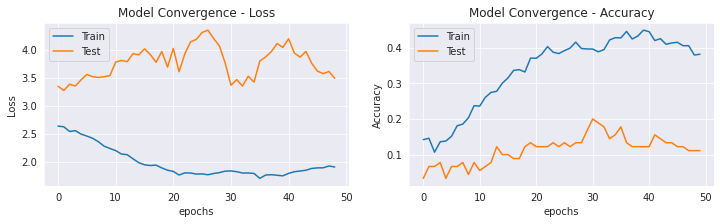

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3))

ax1.plot(loss_treino[1:], label='Train')
ax1.plot(loss_test[1:], label='Test')
ax1.set_title('Model Convergence - Loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(acc_treino, label='Train')
ax2.plot(acc_test, label='Test')
ax2.set_title('Model Convergence - Accuracy')
ax2.set_xlabel('epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

## Usando o modelo

In [52]:
def predict(nome):
  model.eval()

  tns = torch.zeros( len(nome), tam_dicionario )
  for k, letra in enumerate(nome):
    idx = caracteres_validos.find(letra)
    tns[k, idx] = 1
  tns = tns.to(args['device'])

  saida = model(tns)
  topv, topi = saida.data.topk(3, 1, True)

  print(nome)
  for value, index in zip(topv[0], topi[0]):
    print('(%.2f) %s' % (value, categorias[index]))
  print('\n')
  
predict('Mota')
predict('Kamikaze')
predict('Suarez')

Mota
(-1.39) Japanese
(-2.54) Portuguese
(-2.56) German


Kamikaze
(-0.39) Spanish
(-2.39) Scottish
(-2.75) Czech


Suarez
(-0.61) Spanish
(-1.78) Russian
(-2.55) Scottish




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


# Classificando nomes com uma *Character-Level RNN*

Esse notebook foi criado com base no tutorial do PyTorch: <br> 
https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb

### Problema: Dado um nome próprio de entrada, classificar esse nome de acordo com a nacionalidade a que ele pertence.

Entrada: **Hinton**

(-0.47) Scottish

(-1.52) English

(-3.57) Irish


-

Entrada: **Schmidhuber**

(-0.19) German

(-2.48) Czech

(-2.68) Dutch

### Import de bibliotecas

In [53]:
# Para os dados
import unicodedata
import string
import sys, random, os

# Para o processamento e análise
import torch
from torch import nn
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline

In [54]:
args = {
    'lr': 5e-5,
    'regularizacao': 1e-7,
    'num_epocas': 5,
}
args['device'] = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dados de entrada

### Importando dataset

In [55]:
# comente as duas linhas seguintes caso rode mais de uma vez
# !wget https://download.pytorch.org/tutorial/data.zip #
# !unzip data.zip #
############################################################

In [56]:
# Transforma um arquivo de nomes em listas e/ou arrays (nomes, rotulos)
def readLines(filename):
    lines     = open(filename).read().strip().split('\n')
    nomes     = [unicodedata.normalize('NFKD', line).encode('ascii', 'ignore') for line in lines]
    categoria = filename.split('/')[-1].split('.')[0]
    rotulos   = np.repeat( categoria, len(nomes) )

    return nomes, rotulos 


root_path = 'data/names/'
arquivos = sorted(os.listdir(root_path))
categorias = [a[:-4] for a in arquivos]

dados, rotulos = [], []
samples_perclass = []

for file_name in arquivos:
  retorno = readLines(os.path.join(root_path,file_name))
  dados.append(retorno[0])
  rotulos.append(retorno[1])

  samples_perclass.append( (file_name, len(retorno[0])) )


print(samples_perclass, )
print('Minimo amostras', min(samples_perclass, key= lambda k: k[1]), '\n' )

print(dados[categorias.index('Portuguese')][0:10])
print(rotulos[categorias.index('Portuguese')][0:10])

[('Arabic.txt', 2000), ('Chinese.txt', 268), ('Czech.txt', 519), ('Dutch.txt', 297), ('English.txt', 3668), ('French.txt', 277), ('German.txt', 724), ('Greek.txt', 203), ('Irish.txt', 232), ('Italian.txt', 709), ('Japanese.txt', 991), ('Korean.txt', 94), ('Polish.txt', 139), ('Portuguese.txt', 74), ('Russian.txt', 9408), ('Scottish.txt', 100), ('Spanish.txt', 298), ('Vietnamese.txt', 73)]
Minimo amostras ('Vietnamese.txt', 73) 

[b'Abreu', b'Albuquerque', b'Almeida', b'Alves', b'Araujo', b'Araullo', b'Barros', b'Basurto', b'Belo', b'Cabral']
['Portuguese' 'Portuguese' 'Portuguese' 'Portuguese' 'Portuguese'
 'Portuguese' 'Portuguese' 'Portuguese' 'Portuguese' 'Portuguese']


### Convertendo os dados para tensor

**Convertendo os rótulos para tensor**

Representação One-Hot de 18 categorias de idiomas que queremos prever.

In [57]:
def label2tensor(rotulos):
  rotulos_tns = torch.zeros( len(rotulos), 1, dtype=torch.int64 )
  for k, rotulo in enumerate(rotulos):
    idx = categorias.index(rotulo)
    rotulos_tns[k][0] = idx
  return rotulos_tns

rotulos_arabe = rotulos[0]
rotulos_tns = label2tensor(rotulos_arabe)
print(type(rotulos_tns), rotulos_arabe[0], rotulos_tns[0])

<class 'torch.Tensor'> Arabic tensor([0])


**Convertendo os nomes para tensor**

Aqui também usaremos a representação One-Hot, porém teremos que trabalhar com uma lista de tensores, pois os nomes tem comprimentos diferentes. Mais à frente no curso aprenderemos a lidar com isso da forma certa!

In [58]:
caracteres_validos = string.ascii_letters
print(caracteres_validos)
tam_dicionario = len(caracteres_validos)

def nome2tensor(nome):
  tns = torch.zeros( len(nome), tam_dicionario )
  
  for k, letra in enumerate(nome.decode('utf-8')):
    idx = caracteres_validos.find(letra)
    tns[k, idx] = 1

  return tns

dados_arabe = dados[0]
dados_tns = [nome2tensor(dado) for dado in dados_arabe]
print(dados_arabe[0].decode('utf-8')[0],'\n', dados_tns[0][0])


abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ
K 
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


**Amostrando batch balanceado**

In [59]:
num_amostras = min(samples_perclass, key= lambda k: k[1])[1]

def sample_batch(size=num_amostras):
  dados_batch, rotulos_batch = [], []
  for cat in categorias:
    
    amostras_cat = dados[categorias.index(cat)]
    idx = np.random.choice(range(len(amostras_cat)), size=size)
    
    dados_batch.extend([ r for k, r in enumerate(dados[categorias.index(cat)]) if k in idx])
    rotulos_batch.extend([ r for k, r in enumerate(rotulos[categorias.index(cat)]) if k in idx])

  dados_tns = [nome2tensor(dado) for dado in dados_batch]
  return dados_tns, label2tensor(rotulos_batch)

dados_batch, rotulos_batch = sample_batch()
print(len(dados_batch), dados_batch[0].size(), rotulos_batch.size())

1139 torch.Size([7, 52]) torch.Size([1139, 1])


## Modelo Recorrente

* Implemente um modelo para classificação de nomes próprios (série de caracteres) usando apenas camadas *RNNCell*, *Linear* e ativação *LogSoftmax*
* Cada entrada (caracter) possui dimensão (52): alfabeto maiúsculo e minúsculo
* *Hidden size* possui dimensão (256): hiperparâmetro 
* Saída possui dimensão (18): vetor de probabilidade de classes
* Batch size = 1 **pra não termos que lidar com as sequências de tamanho variável.**

### Links úteis

RNNCell: https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html#torch.nn.RNNCell

Linear: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear

Non-linear activations: https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html#torch.nn.LogSoftmax

In [60]:
class RNN(nn.Module):
    def __init__(self, tam_entrada, tam_feature, tam_saida):
        super(RNN, self).__init__()
        
        self.tam_entrada = tam_entrada
        self.tam_feature = tam_feature
        self.tam_saida   = tam_saida
        
        self.rnn    = nn.GRU(self.tam_entrada, self.tam_feature, batch_first=True)
        self.linear = nn.Linear(self.tam_feature, self.tam_saida)
        self.softmax = nn.LogSoftmax(dim=-1)
    
    def forward(self, nome):
      
        # Inicialize o estado interno da RNN
        batch_size = 1
        hidden = torch.zeros(1, batch_size, self.tam_feature).to(args['device'])
        
        # nome.unsqueeze(0) - criando uma dimensão artificial para o batch = 1
        saida, hidden = self.rnn(nome.unsqueeze(0), hidden)
        # print("Saída da GRU:", saida.size())
        saida = self.linear(saida[:, -1])
        # print("Saída da Linear:", saida.size())
        saida = self.softmax(saida) 
        return saida

tam_feature = 256
model = RNN(tam_dicionario, tam_feature, len(categorias))
model.to(args['device'])

# Imprimindo a dimensionalidade do dado ao longo do fluxo
nome = torch.zeros(8, 52).to(args['device'])
saida = model(nome)

## Loss e Otimizador

In [61]:
criterion = nn.NLLLoss().to(args['device']) 
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['regularizacao'])

## Treinamento

A otimização é um processo que tem uma raíz muito bem definida de passo a passo, sempre fazemos:
* Carregar os dados e colocar no dispositivo de hardware adequado
* Forward do dado na rede
* Cálculo da função de custo (no nosso caso uma função composta)
* Passos de Otimização
  * Zerar os gradientes do otimizador (`optimizer.zero_grad()`)
  * Calcular os gradientes com base na loss (`loss.backward()`)
  * Passo de otimização (`optimizer.step()`)

Apesar de cada solução ter pequenas variações em um ou mais passos do fluxo, o esqueleto é sempre o mesmo. 

In [62]:
def forward(X, Y, etapa):
  if etapa == 'Treino': model.train()
  else: model.eval()

  acuracia = 0.
  loss_epoca = []
  for k, (dado, rotulo) in enumerate(zip(X, Y)):
      
    dado = dado.to(args['device'])
    rotulo = rotulo.to(args['device'])
    
    saida = model(dado)
    loss = criterion(saida, rotulo)
    loss_epoca.append(loss.detach().cpu().numpy())

    _, pred = torch.max(saida, axis=-1)
    acuracia += 1 if pred[0].item() == rotulo[0].item() else 0

    if etapa == 'Treino':
      # Otimização
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  loss_epoca = np.asarray(loss_epoca).ravel()
  acuracia   = acuracia/float(len(loss_epoca))
  print('\n','*'*15 + etapa + '*'*15 )
  print('Epoca: {:}, Loss: {:.4f} +/- {:.4f}, Acurácia: {:.4f}'.format(epoca, loss_epoca.mean(), 
                                                                        loss_epoca.std(), 
                                                                        acuracia
                                                                       )) 
  return loss_epoca.mean(), acuracia

In [63]:
loss_treino, loss_test = [], []
acc_treino, acc_test = [], []

dados_test, rotulos_test = sample_batch(size=5)
for epoca in range(50):

  dados_tns, rotulos_tns = sample_batch()
  loss, acuracia = forward(dados_tns, rotulos_tns, 'Treino')
  loss_treino.append(loss)
  acc_treino.append(acuracia)  

  loss, acuracia = forward(dados_test, rotulos_test, 'Teste')
  loss_test.append(loss)
  acc_test.append(acuracia)



 ***************Treino***************
Epoca: 0, Loss: 2.8995 +/- 0.1854, Acurácia: 0.0520

 ***************Teste***************
Epoca: 0, Loss: 2.9034 +/- 0.1831, Acurácia: 0.0787

 ***************Treino***************
Epoca: 1, Loss: 2.7853 +/- 0.5274, Acurácia: 0.0703

 ***************Teste***************
Epoca: 1, Loss: 3.0497 +/- 0.7069, Acurácia: 0.0899

 ***************Treino***************
Epoca: 2, Loss: 2.8663 +/- 0.3914, Acurácia: 0.0942

 ***************Teste***************
Epoca: 2, Loss: 3.0957 +/- 0.8609, Acurácia: 0.0674

 ***************Treino***************
Epoca: 3, Loss: 2.8637 +/- 0.3232, Acurácia: 0.1052

 ***************Teste***************
Epoca: 3, Loss: 3.0601 +/- 0.8325, Acurácia: 0.1011

 ***************Treino***************
Epoca: 4, Loss: 2.8707 +/- 0.2571, Acurácia: 0.1165

 ***************Teste***************
Epoca: 4, Loss: 2.8511 +/- 0.2940, Acurácia: 0.1348

 ***************Treino***************
Epoca: 5, Loss: 2.8045 +/- 0.3400, Acurácia: 0.1503

 **

## Análise de Convergência

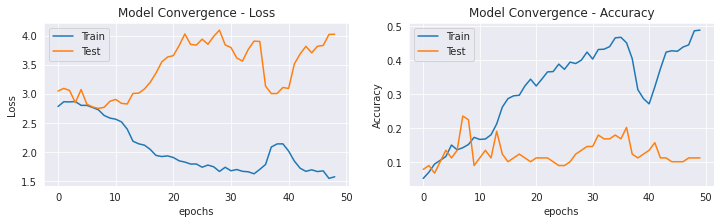

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3))

ax1.plot(loss_treino[1:], label='Train')
ax1.plot(loss_test[1:], label='Test')
ax1.set_title('Model Convergence - Loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(acc_treino, label='Train')
ax2.plot(acc_test, label='Test')
ax2.set_title('Model Convergence - Accuracy')
ax2.set_xlabel('epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

## Usando o modelo

In [65]:
def predict(nome):
  model.eval()

  tns = torch.zeros( len(nome), tam_dicionario )
  for k, letra in enumerate(nome):
    idx = caracteres_validos.find(letra)
    tns[k, idx] = 1
  tns = tns.to(args['device'])

  saida = model(tns)
  topv, topi = saida.data.topk(3, 1, True)

  print(nome)
  for value, index in zip(topv[0], topi[0]):
    print('(%.2f) %s' % (value, categorias[index]))
  print('\n')
  
predict('Merkel')
predict('Hirobumi')
predict('Suarez')

Merkel
(-0.51) Spanish
(-1.81) Scottish
(-2.59) Russian


Hirobumi
(-0.23) Spanish
(-2.52) Arabic
(-2.79) Czech


Suarez
(-0.51) Spanish
(-2.07) Scottish
(-2.52) Russian




# Classificação de sequencias

In [66]:
import os, random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

import torch
from torch import nn, optim
from torchtext.legacy import data
from torchtext.legacy import datasets
import torch.nn.functional as F

SEED = 1234
torch.manual_seed(SEED)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## IMDb Reviews


<img src="https://drive.google.com/uc?export=view&id=1I5dBhbKnPPq-m8CiwaKrvg6LGuT8bkTb" width="700">


## Torchtext

Similar ao torchvision para imagens, o pacote torchtext facilita o trabalho com texto, oferecendo ferramentas aproveitáveis para outros dados sequenciais.

Um dos seus principais elementos é o `Field`, objeto que carrega informações de como os dados devem ser processados. 

No nosso caso temos dois dados:
* Texto: Uma sequência de caracteres que será dividida em **tokens**. Armazenaremos também os tamanhos das frases pois mais a frente veremos como trabalhar com sequências de tamanhos variáveis

  * Ex: "Bom dia Brasil!" $\rightarrow$ `["bom", "dia", "brasil", "!"]`

```python
TEXT = data.Field(tokenize = 'spacy', include_lengths = True)
```

* Label: Categorias descritas como "pos" e "neg". Essas serão transformadas para valores numéricos {neg: 0, pos: 1}

```python
LABEL = data.LabelField(dtype = torch.long)
```



In [67]:
TEXT = data.Field(tokenize = 'spacy', include_lengths = True)
LABEL = data.LabelField(dtype = torch.long)

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [68]:
for sample in valid_data:
  
  print(vars(sample))
  
  texto = sample.text
  label = sample.label

  break

{'text': ['Perhaps', 'I', 'would', 'have', 'liked', 'this', 'film', 'more', 'if', 'I', 'was', "n't", 'so', 'attached', 'to', 'the', 'characters', 'in', 'Henry', 'Fool', '.', 'To', 'those', 'who', "'ve", 'never', 'seen', 'Henry', 'Fool', ',', 'I', 'would', "n't", 'worry', '.', 'As', 'Hartley', 'jokingly', 'said', 'in', 'his', 'introduction', 'to', 'the', 'film', 'at', 'TIFF', ',', 'the', 'film', 'has', 'lots', 'of', 'exposition', 'and', 'explanations.<br', '/><br', '/>This', 'film', 'is', 'very', 'heavy', 'in', 'plot', ',', 'which', 'keeps', 'the', 'film', 'moving', '.', 'There', 'are', 'many', 'humorous', 'moments', 'and', 'the', 'film', 'certainly', 'has', 'Hartley', "'s", 'trademark', 'humour', 'and', 'rhythm', 'of', 'dialogue', '.', 'Over', 'all', ',', 'a', 'technically', 'well', 'made', 'film', 'and', 'sure', 'to', 'satisfy', 'new', 'fans', 'of', 'Hartley', 'who', 'are', 'just', 'beginning', 'explore', 'his', 'work', '.', 'As', 'for', 'the', 'older', 'fans', 'who', 'loved', 'his', 

## Representação do Dado


### Vocabulário

Uma pergunta que pode ter passado na sua cabeça: como alimentamos uma rede neural com palavras de um texto?

Para transformar palavras em dados numéricos, a solução mais simples é mapeá-las em um dicionário contendo o vocabulário completo do conjunto. 

<img src="https://static.packt-cdn.com/products/9781786465825/graphics/B05525_03_01.jpg" width="500">

Podemos fazer isso chamando a função **```build_vocab```** nos nossos fields. Como datasets de texto podem chegar a centenas de milhares de palavras, é importante definir um limite superior para o número de palavras mapeadas pelo dicionário. No código a seguir, esse limite é definido como ```MAX_VOCAB_SIZE = 25000```

Atenção também para o parâmetro ```vectors = "glove.6B.100d"```. O GloVe (Global Vectors) é um método de representação de palavras que explicaremos em maiores detalhes mais a frente. A princípio basta saber que o modelo "glove.**6B**.**100d**" foi treinado em **6 bilhões** de tokens e gera uma representação latente de dimensionalidade  **d = 100**

In [69]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

In [70]:
print('Tamanho do vocabulario', len(TEXT.vocab),'\n')
print(TEXT.vocab.itos[:10],'\n', LABEL.vocab.stoi, '\n')
TEXT.vocab.freqs.most_common(20)

Tamanho do vocabulario 25002 

['<unk>', '<pad>', 'the', ',', '.', 'a', 'and', 'of', 'to', 'is'] 
 defaultdict(None, {'neg': 0, 'pos': 1}) 



[('the', 203104),
 (',', 192504),
 ('.', 165735),
 ('a', 109471),
 ('and', 109283),
 ('of', 101022),
 ('to', 93374),
 ('is', 76440),
 ('in', 61596),
 ('I', 53786),
 ('it', 53290),
 ('that', 49527),
 ('"', 44217),
 ("'s", 43559),
 ('this', 42127),
 ('-', 36893),
 ('/><br', 35922),
 ('was', 35091),
 ('as', 30509),
 ('with', 29878)]

### Embedding Layer

Documentação Pytorch: https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding

Camadas de embedding são treinadas para mapear um ínidice numérico para um vetor denso de maior carga semântica.

Acabamos de ver a representação de palaras como ínidices de um vocabulário fixo. Apesar do índice informar a qual palavra estamos nos referindo, ele não incorpora nenhuma informação semântica sobre a palavra. O treinamento de embeddings para dados textuais tem como objetivo projetar esses índices em um espaço onde palavras semanticamente similares estejam próximas.

![](https://drive.google.com/uc?export=view&id=1pliMSOcjjOZAiR26ycowSeUJsj5cy9W_)

No Pytorch, a instância dessa classe recebe como parâmetro ```(vocab_size, embedding_size, padding_idx)```
* ```vocab_size```: Tamanho do vocabulário. Note que **não** se trata da dimensionalidade da entrada.
* ```embedding_size```: Dimensionalidade da dimensão latente. Caso haja o aproveitamento de embeddings pré treinadas deve-se definir a dimensionalidade da camada em função dos pesos que serão importados (ex: glove.6b.100d, ```embedding_size=100```).


In [71]:
class RNN(nn.Module):
  
  def __init__(self, tam_vocab, tam_embedding, embed_vectors, 
               ind_unk, ind_pad):
    super(RNN, self).__init__()

    # Inicializaremos a camada de embedding
    self.embedding = nn.Embedding(tam_vocab, tam_embedding)
    self.embedding.weight.data.copy_(embed_vectors)
    self.embedding.weight.data[ind_unk] = torch.zeros(tam_embedding)
    self.embedding.weight.data[ind_pad] = torch.zeros(tam_embedding)
    #######################################


  def forward(self, X):
    vectors = self.embedding(X)


tam_vocab = len(TEXT.vocab)
tam_embedding = 100 # glove 100d
embed_vectors = TEXT.vocab.vectors
ind_pad = TEXT.vocab.stoi[TEXT.pad_token]
ind_unk = TEXT.vocab.stoi[TEXT.unk_token]

model = RNN(tam_vocab, tam_embedding, embed_vectors, 
               ind_unk, ind_pad)

print(model)

RNN(
  (embedding): Embedding(25002, 100)
)


## BucketIterator
Essa classe do Torchtext funciona de forma análoga ao DataLoader do PyTorch,  porém leva em consideração a construção de **batches com sequências de comprimento variável**. Internamente ele agrega sequências de comprimento similar, **minimizando a quantidade de padding necessária**. 

Além disso, os dados já saem preparados para serem empacotados pela função ```pack_padded_sequence``` ordenados por comprimento de sequência e informando o comprimento real de cada amostra (sem padding).

> Exemplo: Para compor um tensor com 5 amostras de frases com tamanhos variáveis, a segunda dimensão é definida pela frase de maior comprimento. Amostras menores são complementadas com tokens nulos (`<pad>`). 

<img src="https://drive.google.com/uc?export=view&id=1uOf8NpztcNyV0Dq9Ch5oJoKuPnwPptqK" width="450">


Documentação: https://torchtext.readthedocs.io/en/latest/data.html?highlight=BucketIterator#torchtext.data.BucketIterator


In [72]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

In [73]:
for sample in valid_iterator:

  texto, tamanho = sample.text
  label = sample.label
  
  print(f'Texto: {texto.shape}, Tamanho: {tamanho.shape}, Label: {label.shape} \n', )

  print(tamanho)

  break

Texto: torch.Size([48, 64]), Tamanho: torch.Size([64]), Label: torch.Size([64]) 

tensor([48, 48, 48, 48, 48, 47, 47, 47, 47, 46, 46, 46, 46, 46, 45, 45, 45, 44,
        44, 44, 44, 44, 44, 44, 43, 43, 43, 43, 42, 42, 42, 42, 42, 42, 41, 41,
        40, 40, 40, 39, 39, 39, 38, 38, 38, 36, 36, 36, 35, 34, 34, 33, 33, 33,
        32, 31, 31, 30, 28, 28, 27, 14, 14, 12], device='cuda:0')


## Padding and Packing (Preenchendo e empacotando)

O pacote de funções de rnn, ```nn.utils.rnn```, oferece meios de processar batches contendo sequências de tamanho variável. Isso é realizado através do **padding** da sequência (ex: preenchimento com zeros),  de modo que elas aparentem ter igual comprimento, porém internamente as posições preenchidas não são processadas pela RNN.

*  Vamos lembrar do nosso batch de frases com tamanhos variáveis:

<img src="https://drive.google.com/uc?export=view&id=1uOf8NpztcNyV0Dq9Ch5oJoKuPnwPptqK" width="450">


*  O empacotamento precisa receber os dados em ordem decrescente de comprimento, e internamente são criados "mini batches" com o seu batch. Dessa forma, apenas os timesteps que contém informação relevante sobre o dado são apresentadas à rede. Igualmente, somente esses timesteps impactam no backpropagation.

<img src="https://drive.google.com/uc?export=view&id=1ySh4IdDO4Iw3G8p2iSdo62MW_z4kR5fd" width="450">


Para isso basta realizar o padding das suas sequências, **preservando os comprimetos originais** em outra variável. Na prática, o forward recebe mais um parâmetro, aqui chamamos de **```tamanhos```**, referente ao comprimento de cada amostra dentro do batch **```X```**, ordenado de forma descrescente.

Tendo em mãos (1) o batch de sequências preenchidas e ordenadas, e (2) o comprimento original de cada amostra, basta realizar as seguintes operações no forward da rede:

```python
## Empacote a sequência antes de alimentar a unidade recorrente
packed_input = nn.utils.rnn.pack_padded_sequence(X, tamanhos)

## Forward recorrente
packed_output, hidden = self.rnn(packed_input, hidden )

## Desempacote a sequência para continuar o fluxo na rede.
output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
```

In [74]:
class RNN(nn.Module):
  
  def __init__(self, tam_vocab, tam_embedding, embed_vectors, 
               ind_unk, ind_pad, hidden_size):
    super(RNN, self).__init__()

    # Inicializaremos a camada de embedding
    self.embedding = nn.Embedding(tam_vocab, tam_embedding)
    self.embedding.weight.data.copy_(embed_vectors)
    self.embedding.weight.data[ind_unk] = torch.zeros(tam_embedding)
    self.embedding.weight.data[ind_pad] = torch.zeros(tam_embedding)
    #######################################

    # Camada recorrente
    self.hidden_size = hidden_size
    self.rnn = nn.GRU(tam_embedding, hidden_size)


  def forward(self, X, tamanhos):
    print('X:', X.size(), '\n')
    print('tamanhos', tamanhos, '\n')
    vectors = self.embedding(X)
    print('Vectors:', vectors.size(), '\n')

    hidden = torch.randn(1, X.size(1), self.hidden_size)

    ## Empacote a sequência antes de alimentar a unidade recorrente
    packed_input = nn.utils.rnn.pack_padded_sequence(vectors, tamanhos)
    print('Packed input:', packed_input.batch_sizes, '\n')
    
    ## Forward recorrente
    packed_output, hidden = self.rnn(packed_input, hidden )
    print('Packed output:', packed_output.batch_sizes, '\n')

    ## Desempacote a sequência para continuar o fluxo na rede.
    output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
    print('output:', output.size(), '\n')

    return output


tam_vocab = len(TEXT.vocab)
tam_embedding = 100 # glove 100d
embed_vectors = TEXT.vocab.vectors
ind_pad = TEXT.vocab.stoi[TEXT.pad_token]
ind_unk = TEXT.vocab.stoi[TEXT.unk_token]

hidden_size = 256

model = RNN(tam_vocab, tam_embedding, embed_vectors, 
               ind_unk, ind_pad, hidden_size)

print(model)

RNN(
  (embedding): Embedding(25002, 100)
  (rnn): GRU(100, 256)
)


In [76]:
try:
    for sample in valid_iterator:
        texto, tamanhos = sample.text
        label = sample.label

        saida = model(texto, tamanhos)
        break
except:
    None

X: torch.Size([48, 64]) 

tamanhos tensor([48, 48, 48, 48, 48, 47, 47, 47, 47, 46, 46, 46, 46, 46, 45, 45, 45, 44,
        44, 44, 44, 44, 44, 44, 43, 43, 43, 43, 42, 42, 42, 42, 42, 42, 41, 41,
        40, 40, 40, 39, 39, 39, 38, 38, 38, 36, 36, 36, 35, 34, 34, 33, 33, 33,
        32, 31, 31, 30, 28, 28, 27, 14, 14, 12], device='cuda:0') 



## Classificando Sequências


In [77]:
class RNN(nn.Module):
  
  def __init__(self, tam_vocab, tam_embedding, embed_vectors, 
               ind_unk, ind_pad, hidden_size, output_size):
    super(RNN, self).__init__()

    # Inicializaremos a camada de embedding
    self.embedding = nn.Embedding(tam_vocab, tam_embedding)
    self.embedding.weight.data.copy_(embed_vectors)
    self.embedding.weight.data[ind_unk] = torch.zeros(tam_embedding)
    self.embedding.weight.data[ind_pad] = torch.zeros(tam_embedding)
    #######################################

    self.hidden_size = hidden_size
    self.rnn = nn.GRU(tam_embedding, hidden_size)
    self.linear = nn.Linear(hidden_size, output_size)


  def forward(self, X, tamanhos):
    vectors = self.embedding(X)

    hidden = torch.zeros(1, X.size(1), self.hidden_size).to(device)

    packed_input = nn.utils.rnn.pack_padded_sequence(vectors, tamanhos)
    packed_output, hidden = self.rnn(packed_input, hidden )
    output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
    
    # print('output:', output.size())
    output = F.adaptive_max_pool1d(output.permute(1,2,0), 1)
    # print('output pool:', output.size())
    output = self.linear(output.squeeze())
    # print('output linear:', output.size())

    return output


tam_vocab = len(TEXT.vocab)
tam_embedding = 100 # glove 100d
embed_vectors = TEXT.vocab.vectors
ind_pad = TEXT.vocab.stoi[TEXT.pad_token]
ind_unk = TEXT.vocab.stoi[TEXT.unk_token]

hidden_size = 256
output_size = 2

model = RNN(tam_vocab, tam_embedding, embed_vectors, 
               ind_unk, ind_pad, hidden_size, output_size)

model = model.to(device)

print(model)

RNN(
  (embedding): Embedding(25002, 100)
  (rnn): GRU(100, 256)
  (linear): Linear(in_features=256, out_features=2, bias=True)
)


In [78]:
for sample in valid_iterator:
  texto, tamanhos = sample.text
  label = sample.label

  saida = model(texto, tamanhos.cpu())
  break

### Loss e Otimizador

In [79]:
criterio = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-5)

In [80]:
def forward(iterator, num_samples, etapa):
  if etapa == 'Treino': model.train()
  else: model.eval()

  acuracia = 0.
  loss_epoca = []
  for k, sample in enumerate(iterator):
      
    texto, tamanhos = sample.text
    rotulo = sample.label

    saida = model(texto, tamanhos.cpu())

    loss = criterio(saida, rotulo)
    loss_epoca.append(loss.detach().cpu().numpy())

    _, pred = torch.max(saida, axis=-1)
    acuracia += (pred.cpu().data == rotulo.cpu().data).sum()
    
    if etapa == 'Treino':
      # Otimização
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  loss_epoca = np.asarray(loss_epoca).ravel()
  acuracia   = acuracia/float(num_samples)
  print('\n','*'*15 + etapa + '*'*15 )
  print('Epoca: {:}, Loss: {:.4f} +/- {:.4f}, Acurácia: {:.4f}'.format(epoca, loss_epoca.mean(), 
                                                                        loss_epoca.std(), 
                                                                        acuracia
                                                                       )) 
  return loss_epoca.mean(), acuracia

In [81]:
loss_treino, loss_test = [], []
acc_treino, acc_test = [], []

for epoca in range(25):
  loss, acuracia = forward(train_iterator, len(train_data), 'Treino')
  loss_treino.append(loss)
  acc_treino.append(acuracia)  

  loss, acuracia = forward(valid_iterator, len(valid_data), 'Teste')
  loss_test.append(loss)
  acc_test.append(acuracia)



 ***************Treino***************
Epoca: 0, Loss: 0.6758 +/- 0.0252, Acurácia: 0.5787

 ***************Teste***************
Epoca: 0, Loss: 0.6168 +/- 0.0410, Acurácia: 0.6533

 ***************Treino***************
Epoca: 1, Loss: 0.5479 +/- 0.0610, Acurácia: 0.7285

 ***************Teste***************
Epoca: 1, Loss: 0.5006 +/- 0.0542, Acurácia: 0.7631

 ***************Treino***************
Epoca: 2, Loss: 0.4738 +/- 0.0587, Acurácia: 0.7799

 ***************Teste***************
Epoca: 2, Loss: 0.4597 +/- 0.0607, Acurácia: 0.7852

 ***************Treino***************
Epoca: 3, Loss: 0.4308 +/- 0.0635, Acurácia: 0.8055

 ***************Teste***************
Epoca: 3, Loss: 0.4283 +/- 0.0605, Acurácia: 0.8071

 ***************Treino***************
Epoca: 4, Loss: 0.4100 +/- 0.0671, Acurácia: 0.8159

 ***************Teste***************
Epoca: 4, Loss: 0.4032 +/- 0.0625, Acurácia: 0.8235

 ***************Treino***************
Epoca: 5, Loss: 0.3817 +/- 0.0719, Acurácia: 0.8373

 **

In [82]:
import spacy
nlp = spacy.load('en')

def predict_sentiment(sentence):
    model.eval()
    tokenized = [str(tok) for tok in nlp.tokenizer(sentence)]
    print(tokenized)

    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    print(indexed)
    
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    
    prediction = model(tensor, length_tensor)
    
    return F.softmax(prediction, dim=-1).cpu().data

['Demi', 'and', 'Woody', 'are', 'married', ',', 'but', 'they', "'re", 'poor', '.', 'They', 'meet', 'Robert', 'Redford', ',', 'and', 'he', "'s", 'REALLY', 'rich', '.', 'He', 'takes', 'a', 'fancy', 'to', 'Demi', ',', 'and', 'since', 'he', "'s", 'a', 'gambling', 'man', 'he', 'makes', 'the', 'couple', 'an', '"', 'indecent', 'proposal', ':', '"', 'one', 'million', 'dollars', 'for', 'a', 'night', 'with', 'the', 'little', 'woman.<br', '/><br', '/>At', 'this', 'point', 'you', 'need', 'watch', 'no', 'more', 'of', 'the', 'film', 'because', 'you', 'can', 'put', 'the', 'details', 'together', 'in', 'your', 'sleep', '.', 'Of', 'course', 'Demi', 'is', 'going', 'to', 'accept', 'the', 'offer', '.', 'If', 'she', 'does', "n't", 'there', "'s", 'no', 'first', 'half', 'of', 'the', 'movie', '.', 'Of', 'course', 'it', 'will', 'affect', 'Demi', 'and', 'Woody', "'s", 'marriage', '.', 'If', 'it', 'does', "n't", 'there', "'s", 'no', 'second', 'half', 'of', 'the', 'movie', '.', 'And', 'of', 'course', 'everything',

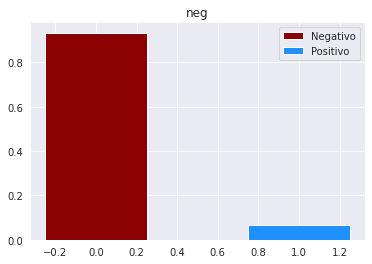

['The', 'people', 'who', 'bash', 'this', 'movie', 'were', 'looking', 'for', 'it', 'to', 'be', 'as', 'cool', 'and', 'slick', 'as', 'the', 'first', 'one', ',', 'which', 'this', 'is', "n't", '.', 'This', 'movie', 'was', 'supposed', 'to', 'be', 'the', 'complete', 'opposite', 'as', 'Ocean', "'s", '11', '.', 'This', 'has', 'been', 'said', 'by', 'a', 'lot', 'of', 'the', 'cast', 'members', 'and', 'also', 'the', 'director', ',', 'Steven', 'Soderbergh', '.', 'Ocean', "'s", '12', ',', 'while', 'it', 'did', 'lack', 'a', 'gripping', 'plot', ',', 'is', 'being', 'bashed', 'because', 'it', 'was', 'different', 'then', 'what', 'people', 'wanted', '.', 'If', 'it', 'were', 'released', 'before', 'Ocean', "'s", '11', ',', 'it', 'would', 'be', 'taken', 'much', 'differently', ',', 'not', 'as', 'a', 'failed', 'sequel', '.', 'The', 'problem', 'with', 'sequels', 'is', 'people', 'go', 'into', 'it', 'with', 'a', 'preset', 'idea', 'of', 'what', 'it', 'should', 'be', 'like', 'it', 'and', 'have', 'lots', 'of', 'expec

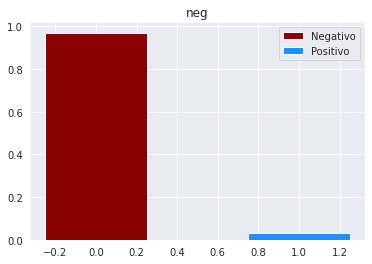

['This', 'was', 'very', 'energetic', 'and', 'well', 'played', 'show', '.', 'I', 'saw', 'it', 'back', 'in', '98', 'and', 'my', 'friends', 'and', 'i', 'still', 'joke', 'about', 'it', '.', 'Each', 'time', 'I', 'watch', 'it', "'s", 'always', 'as', 'funny', 'as', 'the', 'first', '.', 'I', 'also', 'love', 'the', 'way', 'that', 'everyone', 'can', 'relate', 'to', 'it', 'in', 'their', 'own', 'particular', 'ways', '.', 'I', 'am', 'very', 'much', 'looking', 'forward', 'to', 'seeing', 'more', 'of', 'John', "'s", 'own', 'scripts', 'and', 'productions', '.', '<', 'br', '/><br', '/>Unfortunately', 'I', 'ca', "n't", 'find', 'it', 'anywhere', 'for', 'sale', ',', 'and', 'I', "'", 've', 'done', 'quite', 'a', 'lot', 'of', 'looking', '.', 'If', 'anyone', 'knows', 'a', 'website', 'or', 'store', 'to', 'refer', 'me', 'to', ',', 'I', 'would', 'very', 'much', 'appreciate', 'it', 'as', 'I', 'am', 'looking', 'for', 'his', 'other', 'live', 'performances', 'as', 'well', '.', 'Please', 'send', 'me', 'a', 'message', 

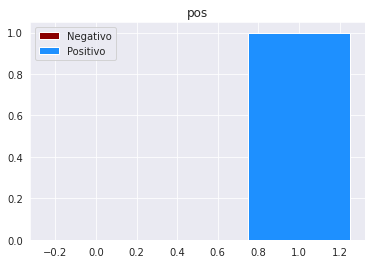

['A', 'touching', 'movie', 'about', 'a', 'talented', 'woman', 'who', 'struggles', 'with', 'a', 'society', 'and', 'a', 'love', 'that', 'structurally', 'underestimate', 'her', '.', 'The', 'issues', 'are', 'subtly', 'addressed', 'and', 'timeless', ',', 'as', 'many', 'of', 'the', 'depicted', 'difficulties', 'between', 'man', 'and', 'woman', 'still', 'exist', 'in', 'Dutch', 'society', 'today', '.', 'This', 'movie', 'is', 'a', 'tribute', 'to', 'all', 'modern', 'women', 'without', 'dwelling', 'on', 'feminism', '.', 'Not', 'only', 'the', 'story', 'is', 'well', 'told', ',', 'the', 'acting', 'and', 'the', 'scenery', 'are', 'great', 'as', 'well', '.']
[148, 1350, 22, 51, 5, 1038, 270, 44, 3246, 21, 5, 989, 6, 5, 143, 13, 0, 0, 48, 4, 25, 1379, 32, 6960, 8540, 6, 4144, 3, 20, 134, 7, 2, 2587, 6134, 215, 161, 6, 270, 158, 1866, 10, 5268, 989, 571, 4, 66, 22, 9, 5, 3730, 8, 41, 730, 387, 242, 13632, 29, 13120, 4, 366, 73, 2, 76, 9, 100, 616, 3, 2, 129, 6, 2, 1376, 32, 103, 20, 100, 4]


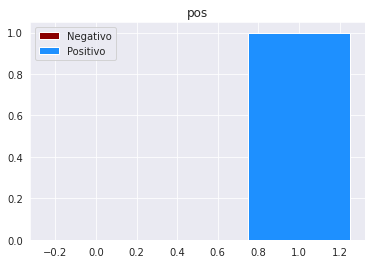

['Navy', 'Seals', 'is', 'an', 'ignorant', ',', 'racist', 'and', 'complacent', 'movie', 'which', 'thoughtlessly', 'uses', 'the', 'Middle', 'East', 'conflict', 'as', 'the', 'backdrop', 'for', 'an', 'action', 'flick', 'concocted', 'for', 'a', 'comfortably', 'sheltered', 'American', 'Mid', '-', 'West', 'audience', '.', 'The', 'conflict', ',', 'as', 'well', 'as', 'those', 'involved', ',', 'is', 'used', 'simply', 'as', 'cannon', 'fodder', 'to', 'glorify', 'the', 'photogenic', 'young', 'Americans', 'who', 'proudly', 'kill', 'Arabs', 'for', 'the', 'good', 'of', "'", 'freedom', "'", '.', 'But', 'what', 'is', 'worse', 'is', 'that', 'the', 'film', "'s", 'action', 'scenes', 'are', 'sloppily', 'handled', 'and', 'unexciting', ',', 'which', 'prevents', 'Navy', 'Seals', 'from', 'working', 'even', 'as', 'a', 'mindless', "shoot-'em", '-', 'up.<br', '/><br', '/>Charlie', 'Sheen', "'s", 'character', '(', 'Hawkins', ')', 'is', 'disgusting', ',', 'obnoxious', ',', 'ignorant', ',', 'reckless', 'and', ',', 'a

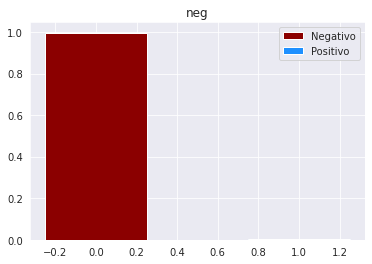

In [83]:
np.random.seed(42)
for i in range(5):
  idx = np.random.choice(len(test_data))
  text = test_data[idx].text 
  pred = predict_sentiment(' '.join(text) )

  plt.bar(0, pred[0], color='darkred', label='Negativo', width=0.5)
  plt.bar(1, pred[1], color='dodgerblue', label='Positivo', width=0.5)
  plt.title(str(test_data[idx].label))
  plt.legend()
  plt.show()